# Map Trove newspaper results by place of publication

In another notebook, I explored some ways in which you could [map Trove newspaper results using the `state` facet](Map-newspaper-results-by-state.ipynb). In this notebook we'll go a bit deeper and map the actual **locations** in which the newspapers returned by our search results were published.

To do this, we'll use the `title` facet. This returns a list of all the newspapers in our results, and the number of matching articles in each.

You can use this notebook to visualise your own search queries, just edit the search parameters were indicated.


<div class="alert alert-block alert-warning">
<p>If you haven't used one of these notebooks before, they're basically web pages in which you can write, edit, and run live code. They're meant to encourage experimentation, so don't feel nervous. Just try running a few cells and see what happens!.</p>

<p>
    Some tips:
    <ul>
        <li>Code cells have boxes around them. When you hover over them a <i class="fa-step-forward fa"></i> icon appears.</li>
        <li>To run a code cell either click the <i class="fa-step-forward fa"></i> icon, or click on the cell and then hit <b>Shift+Enter</b>. The <b>Shift+Enter</b> combo will also move you to the next cell, so it's a quick way to work through the notebook.</li>
        <li>While a cell is running a <b>*</b> appears in the square brackets next to the cell. Once the cell has finished running the asterix will be replaced with a number.</li>
        <li>In most cases you'll want to start from the top of notebook and work your way down running each cell in turn. Later cells might depend on the results of earlier ones.</li>
        <li>To edit a code cell, just click on it and type stuff. Remember to run the cell once you've finished editing.</li>
    </ul>
</p>
</div>

## Add your API key

You need an [API key](http://help.nla.gov.au/trove/building-with-trove/api) to get data from Trove.

In [15]:
# This creates a variable called 'api_key', paste your key between the quotes
# <-- Then click the run icon 
api_key = ''

# This displays a message with your key
print('Your API key is: {}'.format(api_key))

Your API key is: 


## Setting things up

You don't need to edit anything here. Just run the cells to load the bits and pieces we need.

In [2]:
# Import the libraries we need
# <-- Click the run icon 
import requests
import pandas as pd
import os
import altair as alt
import json
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
import numpy as np
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
# Set up default parameters for our API query
# <-- Click the run icon 
params = {
    'zone': 'newspaper',
    'encoding': 'json',
    'facet': 'title',
    'n': '1',
    'key': api_key
}

api_url = 'http://api.trove.nla.gov.au/v2/result'

## Construct your search

This is where you set your search keywords. Change 'weather AND wragge date:[* TO 1954]' in the cell below to anything you might enter in the Trove simple search box. For example:

`params['q'] = 'weather AND wragge'`

`params['q'] = '"Clement Wragge"'`

`params['q'] = 'text:"White Australia Policy"'`

`params['q'] = 'weather AND date:[1890-01-01T00:00:00Z TO 1920-12-11T00:00:00Z]'`

You can also limit the results to specific categories. To only search for articles, include this line:

`params['l-category'] = 'Article'`

In [4]:
# Enter your search parameters
# This can be anything you'd enter in the Trove simple search box
params['q'] = 'weather AND wragge date:[* TO 1954]'

# Remove the "#" symbol from the line below to limit the results to the article category
#params['l-category'] = 'Article'

## Get the data from Trove

Everything's set up, so just run the cells!

### Make an API request

In [5]:
# <-- Click the run icon 
response = requests.get(api_url, params=params)
data = response.json()

### Reformat the results

In [6]:
# <-- Click the run icon 
def format_facets(data):
    facets = data['response']['zone'][0]['facets']['facet']['term']
    df = pd.DataFrame(facets)
    df = df[['display', 'count']]
    df.columns = ['title_id', 'total']
    df['total'] = pd.to_numeric(df['total'], errors='coerce')
    return df
df = format_facets(data)
df.head()

,title_id,total
0,840,4840
1,16,4815
2,508,1688
3,10,1550
4,74,1513


## Load location data

I've previously created a [CSV file](data/trove-newspaper-titles-locations.csv) that provides geolocated places of publication for newspapers in Trove. Some newspapers are associated with multiple places (for example a cluster of nearby country towns), so the CSV file can contain multiple rows for a single newspaper title. Note also that any newspapers that were added to Trove since I last harvested the locations in April 2018 will drop out of the data.

We're going to merge the facets data with my geolocated titles file, matching on the `title_id`. We'll only take the first matching row from the geolocated data.

In [7]:
# Get the geolocated data
locations = pd.read_csv('data/trove-newspaper-titles-locations.csv', names=['title_id', 'title', 'state', 'place_id', 'place', 'lat', 'lon'])
# Only keep the first instance of each title
locations.drop_duplicates(subset=['title_id'], keep='first', inplace=True)
# Merge the facets and the geolocated data
df_located = pd.merge(df, locations, on='title_id', how='left')
df_located.head()

,title_id,total,title,state,place_id,place,lat,lon
0,840,4840,"The Telegraph (Brisbane, Qld. : 1872 - 1947)",QLD,QLD4555,Brisbane,-27.467848,153.028013
1,16,4815,The Brisbane Courier (Qld. : 1864 - 1933),QLD,QLD4555,Brisbane,-27.467848,153.028013
2,508,1688,"Evening News (Sydney, NSW : 1869 - 1931)",NSW,NSW79218,Sydney,-33.873200,151.209600
3,10,1550,"The Mercury (Hobart, Tas. : 1860 - 1954)",TAS,TAS00752,Hobart,-42.880001,147.320007
4,74,1513,Launceston Examiner (Tas. : 1842 - 1899),TAS,TAS00338,Launceston,-41.439999,147.139999


## Display top 20 newspapers

Now we have titles for our newspaper facets, let's chart the top twenty.

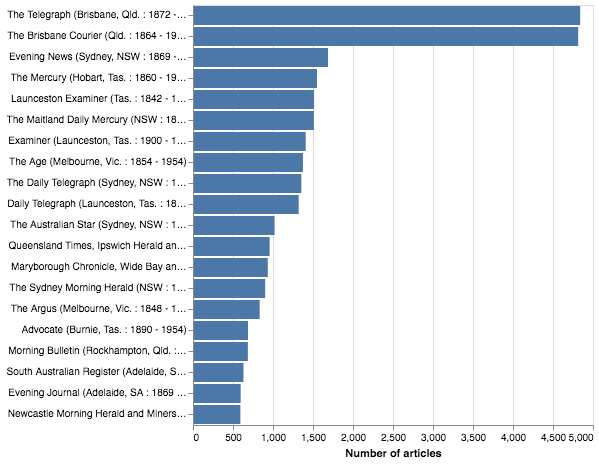

In [8]:
alt.Chart(df_located[:20]).mark_bar().encode(
    y=alt.Y('title', sort=df_located['title'][:20].tolist(), title=''),
    x=alt.X('total', title='Number of articles')
)

## Map places of publication

More than one newspaper can be associated with a place, so rather than map individual newspapers, we'll group them by place.

In [9]:
# Group newspapers by place
df_places = df_located.groupby(['place', 'lat', 'lon'])

Here's the fun part. We'll create a map, then we'll loop through the places, getting the total number of articles from all the grouped newspapers.

In [14]:
m = folium.Map(
    location=[-30, 135],
    zoom_start=4
)
# We'll cluster the markers for better readability
marker_cluster = MarkerCluster().add_to(m)

for place, group in df_places:
    # Get the total articles from the grouped titles
    total = group['total'].sum()
    # Turn all the grouped title_ids into a string that we can use in a Trove search url
    titles = group['title_id'].astype('str').str.cat(sep='&l-title=')
    # Create the content of the marker popup -- includes a search link back to Trove!
    html = '<b>{}</b><br><a target="_blank" href="https://trove.nla.gov.au/newspaper/result?q={}&l-title={}&l-category={}">{} articles'.format(place[0], params['q'], titles, params.get('l-category', ''), total)
    # Add the marker to the map
    folium.Marker([place[1], place[2]], popup=html).add_to(marker_cluster)

m

Play around with the map. Note the link on the total number of articles in the pop-ups — it should open Trove and find the matching articles!

## Make a heatmap

The map above is great from browsing, but doesn't give much of a sense of the **number** of results in each place. Let's try creating a heatmap instead.

To populate a heatmap we just need a list of coordinates — one set of coordinates for each article.

In [11]:
# Get the total number of articles for each place
df_totals = df_places.sum()
locations = []
# Loop through the places
for place in df_totals.index:
    # Get the total
    total = df_totals.loc[place]['total']
    # Add the coordinates of the place to the list of locations as many times as there are articles
    locations += ([[place[1], place[2]]] * total)

In [12]:
# Create another map
m2 = folium.Map(
    location=[-30, 135],
    zoom_start=4
)

#Add the heatmap data!
HeatMap(locations).add_to(m2)
m2

That's looking pretty interesting. Hmmmm, it would be nice if we could animate this through time, but we'd need more data. Perhaps a [future notebook](Map-newspaper-results-by-place-of-publication-over-time.ipynb) topic?